In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os 
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_path = '/kaggle/input/smoking/Training/Training'
test_path = '/kaggle/input/smoking/Testing/Testing'
valid_path = '/kaggle/input/smoking/Validation/Validation'

In [3]:
def extract_from_path(path)-> []:
    full_path = []
    for i in sorted(os.listdir(path)):
        full_path.append(os.path.join(path, i))
    return full_path

In [4]:
train_images = extract_from_path(train_path)
test_images = extract_from_path(test_path)
valid_images = extract_from_path(valid_path)

print(f"The length of train_images is {len(train_images)}")
print(f"The length of test_images is {len(test_images)}")
print(f"The length of valid_images is {len(valid_images)}")

The length of train_images is 716
The length of test_images is 224
The length of valid_images is 180


In [5]:
def createDataFrame(image_paths):
    labels = [path.split('/')[-1].split('_')[0] for path in image_paths]
    df = pd.DataFrame({'path': image_paths, 'label': labels})
    df['label_id'] = df['label'].apply(lambda x: 1 if x == 'smoking' else 0)
    return df

In [6]:
train_images_df = createDataFrame(train_images)
test_images_df = createDataFrame(test_images)
valid_images_df = createDataFrame(valid_images)

In [7]:
def plotCount(df):
    name = df["path"][0].split("/")[4]
    smoking = df[df['label_id'] == 1]    
    print(f"Total images in {name} is {len(df)}")
    print(f"Total smoking images is {len(smoking)}")
    print(f"Total non-smoking images is {len(df)-len(smoking)}")
    sns.set_style("whitegrid")
    sns.countplot(x='label_id', data=df)


In [8]:
import tensorflow as tf

IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
SEED = 42

def imgPreProcessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMAGE_SIZE))
    return img, label
def loadDataset(df:pd.DataFrame):
    dataset = tf.data.Dataset.from_tensor_slices((df['path'], df['label_id']))
    return (dataset
                 .map(imgPreProcessing)
                .shuffle(BATCH_SIZE * 20)
                 .batch(BATCH_SIZE))
                

In [9]:
train_data = loadDataset(train_images_df)
test_data = loadDataset(test_images_df)
valid_data = loadDataset(valid_images_df)

In [10]:
def plotRandom(data):
    for img,label in data.take(1):
        randomNum = random.randint(0, BATCH_SIZE - 1)
        text_label = "Smoking" if label[randomNum].numpy() == 1 else "Non-Smoking"
        plt.figure(figsize=(4, 4))
        plt.imshow(img[randomNum]/255.)
        plt.title(text_label)
        plt.axis('off') 
        plt.show()


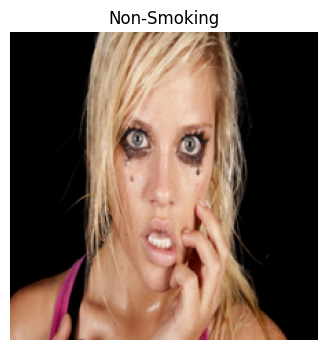

In [11]:
plotRandom(train_data)

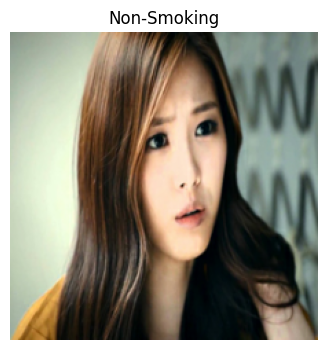

In [12]:
plotRandom(train_data)


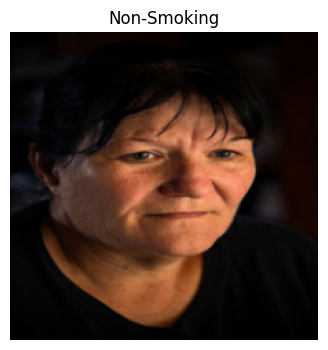

In [13]:
plotRandom(test_data)


In [14]:
def create_b0_base(lr:float = 0.001)->tf.keras.Model:
    model = tf.keras.applications.Xception(include_top=False)
    model.trainable = False
    
    input_ = tf.keras.layers.Input(shape = IMAGE_SIZE + (3,), name = "input layer")
    x = model(input_)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    output = tf.keras.layers.Dense(2,activation = "sigmoid")(x)
    
    base_model = tf.keras.Model(input_,output)
    base_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),optimizer = tf.keras.optimizers.Lion(learning_rate = lr), metrics = ["accuracy"])
    return base_model

In [15]:
def plot_history(model_history):
    plt.style.use("seaborn-v0_8-whitegrid")
    df = pd.DataFrame(model_history.history)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    loss = df['loss']
    accuracy = df['accuracy']
    val_loss = df['val_loss']
    val_accuracy = df['val_accuracy']
    epochs = range(len(df['val_loss']))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss')
    ax1.plot(epochs, val_loss, label='val_loss')
    ax1.legend()
    ax1.set_xlabel('Epochs')
    ax1.set_title("Loss")
    
    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy')
    ax2.plot(epochs, val_accuracy, label='val_accuracy')
    ax2.set_xlabel('Epochs')
    ax2.legend()
    ax2.set_title("Accuracy")
    
    # Adjust spacing and titles
    plt.tight_layout()
    plt.show()

In [16]:
base_eff0 = create_b0_base()
# fit the model
base_eff0_history = base_eff0.fit(train_data,epochs = 100,validation_data = valid_data)

83683744/83683744 [==============================] - 1s 0us/step
Epoch 1/100
23/23 [==============================] - 13s 271ms/step - loss: 2.7944 - accuracy: 0.6341 - val_loss: 3.4871 - val_accuracy: 0.5889
Epoch 2/100
23/23 [==============================] - 4s 146ms/step - loss: 2.1392 - accuracy: 0.6578 - val_loss: 2.5165 - val_accuracy: 0.6111
Epoch 3/100
23/23 [==============================] - 4s 146ms/step - loss: 1.9162 - accuracy: 0.6592 - val_loss: 2.5419 - val_accuracy: 0.6333
Epoch 4/100
23/23 [==============================] - 4s 147ms/step - loss: 1.5594 - accuracy: 0.6983 - val_loss: 2.1919 - val_accuracy: 0.6889
Epoch 5/100
23/23 [==============================] - 4s 148ms/step - loss: 1.6280 - accuracy: 0.7249 - val_loss: 1.9032 - val_accuracy: 0.6500
Epoch 6/100
23/23 [==============================] - 4s 147ms/step - loss: 1.4462 - accuracy: 0.7123 - val_loss: 1.9496 - val_accuracy: 0.6444
Epoch 7/100
23/23 [==============================] - 4s 149ms/step - loss: 1

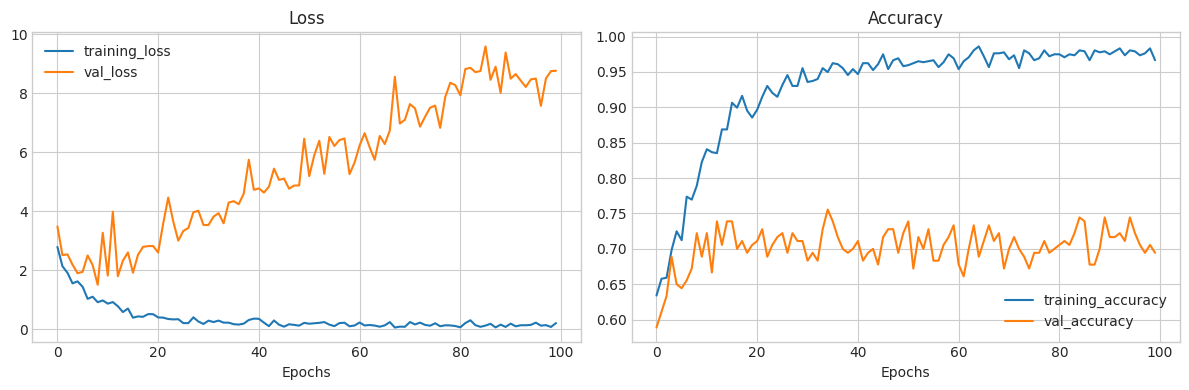

In [17]:
plot_history(base_eff0_history)


In [18]:
base_eff0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, None, None, 2048   20861480  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 20865578 (79.60 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [19]:
def create_b0_base(lr:float = 0.001)->tf.keras.Model:
    model = tf.keras.applications.MobileNetV3Large(include_top=False)
    model.trainable = False
    
    input_ = tf.keras.layers.Input(shape = IMAGE_SIZE + (3,), name = "input layer")
    x = model(input_)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    output = tf.keras.layers.Dense(2,activation = "sigmoid")(x)
    
    base_model = tf.keras.Model(input_,output)
    base_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),optimizer = tf.keras.optimizers.Lion(learning_rate = lr), metrics = ["accuracy"])
    return base_model

In [20]:
from tqdm.keras import TqdmCallback

In [21]:
base_eff0 = create_b0_base()
tqdm_callback = TqdmCallback(verbose=1)
base_eff0_history = base_eff0.fit(train_data,epochs = 100,validation_data = valid_data, callbacks=tqdm_callback, verbose=0)

12683000/12683000 [==============================] - 0s 0us/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

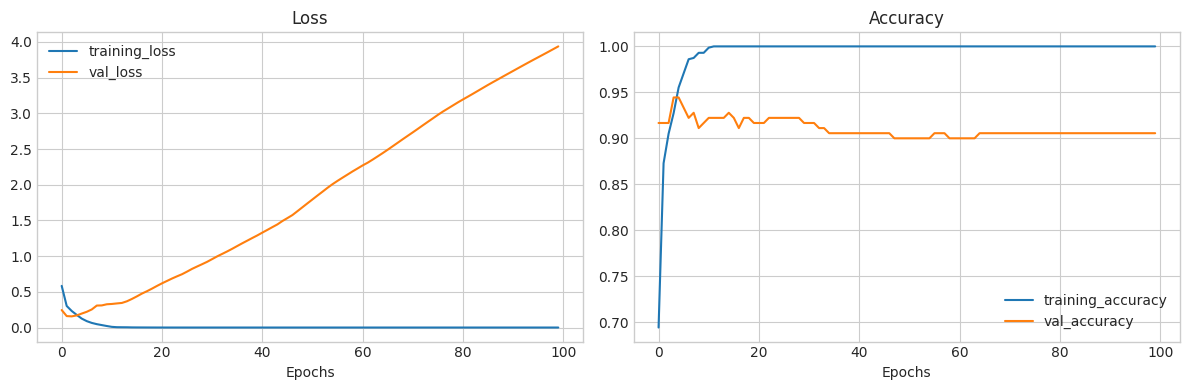

In [22]:
plot_history(base_eff0_history)


In [23]:
def create_b0_base(lr:float = 0.001)->tf.keras.Model:
    model = tf.keras.applications.EfficientNetB7(include_top=False)
    model.trainable = False
    
    input_ = tf.keras.layers.Input(shape = IMAGE_SIZE + (3,), name = "input layer")
    x = model(input_)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    output = tf.keras.layers.Dense(2,activation = "sigmoid")(x)
    
    base_model = tf.keras.Model(input_,output)
    base_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),optimizer = tf.keras.optimizers.Lion(learning_rate = lr), metrics = ["accuracy"])
    return base_model

In [24]:
base_eff0 = create_b0_base()
tqdm_callback = TqdmCallback(verbose=1)
base_eff0_history = base_eff0.fit(train_data,epochs = 100,validation_data = valid_data, callbacks=tqdm_callback, verbose=0)

258076736/258076736 [==============================] - 1s 0us/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2024-01-17 15:31:31.580776: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


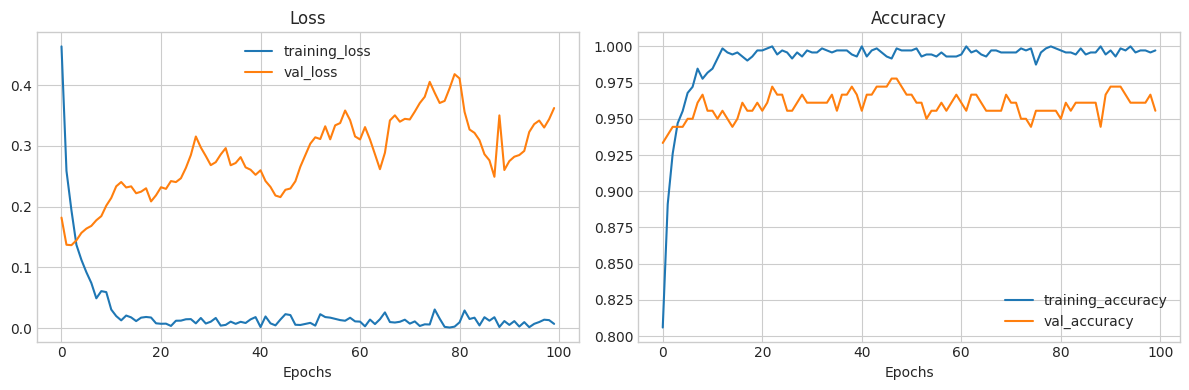

In [25]:
plot_history(base_eff0_history)